In [1]:
from miso.hist_features import get_features
from miso.utils import *
from miso import Miso
from PIL import Image
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
Image.MAX_IMAGE_PIXELS = None
Image.MAX_IMAGE_PIXELS = None
import torch
import random

seed=100
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA is available. GPU:", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print("CUDA is not available. Using CPU.")


CUDA is available. GPU: NVIDIA A100-SXM4-80GB


In [2]:
#install gdown package for downloading tutorial data
!python -m pip install gdown

In [3]:
#download the miso_tutorial_data folder 
!gdown --folder https://drive.google.com/drive/folders/1G4sMqK4kinJ81rTWJkMgWt_mfZEZyaSZ?usp=drive_link
#set working directory to miso_tutorial_data
os.chdir('miso_tutorial_data')

Retrieving folder contents
Processing file 1253InghpAya2vL9SoFGiwqTT2Y2y_H0Z he-raw.tif
Processing file 1dOXTMkqqi_GQgMKUCz1jRONHgXwmGyWv locs.csv
Processing file 1zue4elVDvQztzK1VfaSKunRw-0KWoyPt protein.h5ad
Processing file 1X_uc2bLUS7wYcAL_ICns6a5U-q7TgCu6 rna.h5ad
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1253InghpAya2vL9SoFGiwqTT2Y2y_H0Z
From (redirected): https://drive.google.com/uc?id=1253InghpAya2vL9SoFGiwqTT2Y2y_H0Z&confirm=t&uuid=f7d423a1-f9d2-413c-9775-aac22b63b627
To: /home/kylecole/git_repos/miso/tutorial/miso_tutorial_data/he-raw.tif
100%|█████████████████████████████████████████| 938M/938M [00:08<00:00, 111MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dOXTMkqqi_GQgMKUCz1jRONHgXwmGyWv
To: /home/kylecole/git_repos/miso/tutorial/miso_tutorial_data/locs.csv
100%|████████████████████████████████████████| 158k/158k [00:00<00:00, 3.37MB/s]
D

In [4]:
#If an H&E image is available, this code chunk extracts spot-level histology features
im = Image.open('he-raw.tif')


#microns per pixel in H&E image
pixel_size_raw = 65/255.54640512302527

#desired microns per pixel
pixel_size = 0.5

#spot radius in pixels
rad=55/(2*pixel_size_raw)

#spot spatial locations
#column 1: binary indicator for whether spot is in tissue; column 2: row coordinate of spot in array; column 3: column coordinate of spot in array; column 4: row pixel coordinate of spot; column 5: column pixel coordinate of spot; 
locs = pd.read_csv('locs.csv', index_col = 0)
locs.columns = [str(i) for i in range(1,6)]
image_emb = get_features(im,locs,rad,pixel_size_raw,pixel_size,pretrained=True,device=device)
np.save('image_emb.npy', image_emb)

Scaling image
Preprocessing image
Adjusting margins


Extracting image features: 1/4:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting image features: 2/4:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting image features: 3/4:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting image features: 4/4:   0%|          | 0/4 [00:00<?, ?it/s]

Smoothing embeddings


In [5]:
#Load data and perform necessary preprocessing
rna = sc.read('rna.h5ad')
rna = preprocess(rna,modality='rna')

protein = sc.read('protein.h5ad')
protein = preprocess(protein,modality='protein')

/home/kylecole/anaconda3/envs/miso/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
#if using a subset of modality-specific terms, the "ind_views" parameter should be a list with values entries to the indices of the modalities to be included, e.g.,  ind_views=[0,2] if including RNA and image features
#if using a subset of interaction terms, the "combs" parameter should be a list of tuples with entries to the indices of the modalities for each interaction, e.g. combs = [(0,1),(0,2)] if including the RNA-protein and RNA-image interaction terms
model = Miso([rna,protein,image_emb],ind_views='all',combs='all',sparse=False,device=device)
model.train()
np.save('emb.npy', model.emb)

Training network for modality 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training network for modality 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training network for modality 3:   0%|          | 0/1000 [00:00<?, ?it/s]

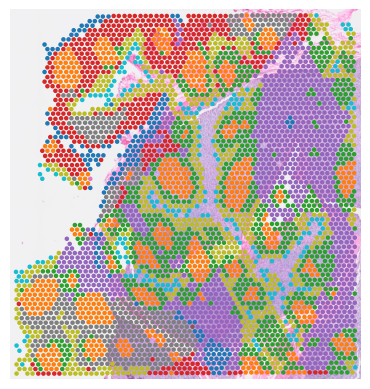

In [7]:
clusters = model.cluster(n_clusters=10)
im_lowres = plt.imread('tissue_hires_image.png')
scale = 0.051109068
plot_on_histology(clusters,locs,im_lowres,scale,s=5)